# Overview
Since the discussion from the [top](https://www.kaggle.com/agoodman) (yet illegible) of leaderboard mention [RCNN](https://www.kaggle.com/c/data-science-bowl-2018/discussion/48130), and the Kaggle staff were quick to add it to the [kernel](https://github.com/Kaggle/docker-python/pull/173). This kernel is a simple example of how to apply this
1. the preprocessing steps to load the data
1. a quick visualization of the color-space
1. training a simple RCNN
1. applying the model to the test data
1. creating the RLE test data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
dsb_data_dir = os.path.join('..', 'input')
stage_label = 'stage1'

# Read in the labels
Load the RLE-encoded output for the training set

In [2]:
train_labels = pd.read_csv(os.path.join(dsb_data_dir,'{}_train_labels.csv'.format(stage_label)))
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)

ImageId  \
3735   1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1...   
4893   23830d0e51245fc0c9e410efa4c17d2a7d83a0104a3777...   
17196  947c0d94c8213ac7aaa41c4efc95d854246550298259cf...   

                                           EncodedPixels  
3735   [110259, 5, 110777, 8, 111295, 12, 111813, 15,...  
4893   [51007, 6, 51262, 10, 51518, 11, 51773, 13, 52...  
17196  [13155, 3, 13409, 5, 13417, 1, 13664, 5, 13673...

# Load in all Images
Here we load in the images and process the paths so we have the appropriate information for each image

In [3]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('/')[-3]
img_type = lambda in_path: in_path.split('/')[-2]
img_group = lambda in_path: in_path.split('/')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('/')[-4].split('_')[0]
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)

path  \
2214   ../input/stage1_train/bf7691b0a79811fa068b7408...   
29215  ../input/stage1_train/e23e11414ee645b51081fb20...   

                                                 ImageId ImageType  \
2214   bf7691b0a79811fa068b7408cbce636a73f01ef9e971a9...     masks   
29215  e23e11414ee645b51081fb202d38b793f0c8ef2940f822...     masks   

      TrainingSplit   Stage  
2214          train  stage1  
29215         train  stage1

# Create Training Data
Here we make training data and load all the images into the dataframe. We take a simplification here of grouping all the regions together (rather than keeping them distinct).

In [4]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['mask_paths'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['image_paths'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['images'] = train_img_df['image_paths'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
def read_and_stack_masks(in_img_list):
    return np.sum(np.stack([i*(imread(c_img)>0) for i, c_img in 
                            enumerate(in_img_list,1)], 0), 0)
train_img_df['masks'] = train_img_df['mask_paths'].map(read_and_stack_masks).map(lambda x: x.astype(int))
train_img_df.sample(1)

CPU times: user 1min 24s, sys: 57 s, total: 2min 21s
Wall time: 2min 21s


# Show a few images
Here we show a few images of the cells where we see there is a mixture of brightfield and fluorescence which will probably make using a single segmentation algorithm difficult

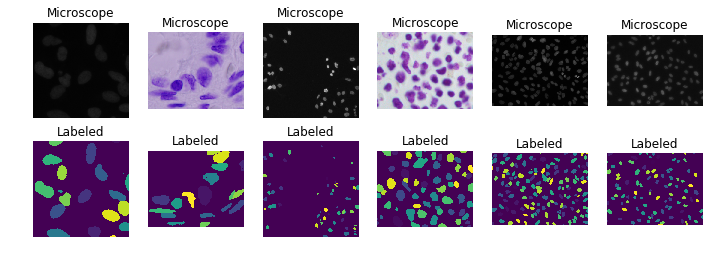

In [5]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

# Check Dimensions 
Here we show the dimensions of the data to see the variety in the input images

In [6]:
train_img_df['images'].map(lambda x: x.shape).value_counts()

(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: images, dtype: int64

In [7]:
train_img_df.sample(1)

ImageId   Stage  \
542  cdab367b30db47061df837c1ae9fa875d6057614f79733...  stage1   

                                           image_paths  \
542  [../input/stage1_train/cdab367b30db47061df837c...   

                                            mask_paths  \
542  [../input/stage1_train/cdab367b30db47061df837c...   

                                                images  \
542  [[[0.113725490196, 0.113725490196, 0.113725490...   

                                                 masks  
542  [[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, ...

# Create a fancy dictionary with bounding boxes
Reformat the data for bounding box style annotation

In [8]:
from skimage.morphology import label
from skimage.measure import regionprops
train_dict = [dict(image = dict(
    pathname = c_row['image_paths'][0],
                  shape =  dict(zip(['r', 'c', 'channels'], c_row['images'].shape))),
                   objects = [{'bounding_box' : dict(
                    minimum = dict(r = c_reg.bbox[0], c = c_reg.bbox[1]),
                   maximum = dict(r = c_reg.bbox[2], c = c_reg.bbox[3])),
                                  'class' : "nucleus",
                               'mask': dict(pathname = c_path)
                              }
                                   for c_reg, c_path in zip(
                                       regionprops(label(c_row['masks'])),
                                       c_row['mask_paths']
                                   )]
                  ) 
              for _, c_row in train_img_df.iterrows()]
print(str(train_dict[0])[:500])

{'image': {'pathname': '../input/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png', 'shape': {'r': 256, 'c': 256, 'channels': 3}}, 'objects': [{'bounding_box': {'minimum': {'r': 0, 'c': 188}, 'maximum': {'r': 8, 'c': 206}}, 'class': 'nucleus', 'mask': {'pathname': '../input/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/ffae764df84788e8047c0942f55676c96632


## An Improved Data Generator
I stole this nice generator from the latest [pull request](https://github.com/broadinstitute/keras-rcnn/blob/f37ffa61a1b8bbed19b667ffb01a1c35e5a84db6/keras_rcnn/preprocessing/_image_segmentation.py) on the rcnn repo, thanks [Allen](https://github.com/0x00b1)

In [9]:
import keras.backend
import keras.preprocessing.image
import numpy
import skimage.io
import skimage.transform

def scale_size(size, min_size, max_size):
    """
    Rescales a given image size such that the larger axis is
    no larger than max_size and the smallest axis is as close
    as possible to min_size.
    """
    assert (len(size) == 2)

    scale = min_size / numpy.min(size)

    # Prevent the biggest axis from being larger than max_size.
    if numpy.round(scale * numpy.max(size)) > max_size:
        scale = max_size / numpy.max(size)

    rows, cols = size
    rows *= scale
    cols *= scale

    return (int(rows), int(cols)), scale


class DictionaryIterator(keras.preprocessing.image.Iterator):
    def __init__(
            self,
            dictionary,
            classes,
            generator,
            target_shape=None,
            scale=1,
            ox=None,
            oy=None,
            batch_size=1,
            shuffle=False,
            seed=None
    ):
        self.dictionary = dictionary
        self.classes = classes
        self.generator = generator

        r = dictionary[0]["image"]["shape"]["r"]
        c = dictionary[0]["image"]["shape"]["c"]

        channels = dictionary[0]["image"]["shape"]["channels"]

        self.image_shape = (r, c, channels)
        self.scale = scale
        self.ox = ox
        self.oy = oy

        self.batch_size = batch_size

        if target_shape is None:
            self.target_shape, self.scale = scale_size(self.image_shape[0:2], numpy.min(self.image_shape[:2]), numpy.max(self.image_shape[:2]))

            self.target_shape = self.target_shape + (self.image_shape[2],)

        else:
            self.target_shape = target_shape + (self.image_shape[2],)

        # Metadata needs to be computed only once.
        r, c, channels = self.target_shape

        self.target_metadata = numpy.array([[r, c, self.scale]])

        super(DictionaryIterator, self).__init__(len(self.dictionary), batch_size, shuffle, seed)

    def next(self):
        with self.lock:
            selection = next(self.index_generator)

        return self._get_batches_of_transformed_samples(selection)

    def _get_batches_of_transformed_samples(self, selection):
        # Labels has num_classes + 1 elements, since 0 is reserved for
        # background.
        num_classes = len(self.classes)

        target_bounding_boxes = numpy.zeros((self.batch_size, 0, 4), dtype=keras.backend.floatx())

        target_images = numpy.zeros((self.batch_size,) + self.target_shape, dtype=keras.backend.floatx())

        target_masks = numpy.zeros((self.batch_size,) + self.target_shape, dtype=keras.backend.floatx())

        target_scores = numpy.zeros((self.batch_size, 0, num_classes + 1), dtype=numpy.uint8)

        for batch_index, image_index in enumerate(selection):
            count = 0

            while count == 0:
                # Image
                target_image_pathname = self.dictionary[image_index]["image"]["pathname"]

                target_image = skimage.io.imread(target_image_pathname)[:, :, :3]

                if target_image.ndim == 2:
                    target_image = numpy.expand_dims(target_image, -1)

                # crop
                if self.ox is None:
                    offset_x = numpy.random.randint(0, self.image_shape[1] - self.target_shape[1] + 1)
                else:
                    offset_x = self.ox

                if self.oy is None:
                    offset_y = numpy.random.randint(0, self.image_shape[0] - self.target_shape[0] + 1)
                else:
                    offset_y = self.oy

                target_image = target_image[offset_y:self.target_shape[0] + offset_y, offset_x:self.target_shape[1] + offset_x, :]

                # Copy image to batch blob.
                target_images[batch_index] = skimage.transform.rescale(target_image, scale=self.scale, mode="reflect")

                # Set ground truth boxes.
                for object_index, b in enumerate(self.dictionary[image_index]["objects"]):
                    if b["class"] not in self.classes:
                        continue

                    bounding_box = b["bounding_box"]

                    minimum_c = bounding_box["minimum"]["c"] - offset_x
                    minimum_r = bounding_box["minimum"]["r"] - offset_y

                    maximum_c = bounding_box["maximum"]["c"] - offset_x
                    maximum_r = bounding_box["maximum"]["r"] - offset_y

                    if maximum_c == target_image.shape[1]:
                        maximum_c -= 1

                    if maximum_r == target_image.shape[0]:
                        maximum_r -= 1

                    if minimum_c >= 0 and maximum_c < target_image.shape[1] and minimum_r >= 0 and maximum_r < target_image.shape[0]:
                        count += 1

                        target_bounding_box = [
                            minimum_c,
                            minimum_r,
                            maximum_c,
                            maximum_r
                        ]

                        target_bounding_boxes = numpy.append(target_bounding_boxes, [[target_bounding_box]], axis=1)

                        target_score = [0] * (num_classes + 1)

                        target_score[self.classes[b["class"]]] = 1

                        target_scores = numpy.append(target_scores, [[target_score]], axis=1)

            # Scale the ground truth boxes to the selected image scale.
            target_bounding_boxes[batch_index, :, :4] *= self.scale

        return [target_bounding_boxes, target_images, target_masks, self.target_metadata, target_scores], None


class ImageSegmentationGenerator:
    def flow(self, dictionary, classes, target_shape=None, scale=None, ox=None, oy=None, batch_size=1, shuffle=True, seed=None):
        return DictionaryIterator(dictionary, classes, self, target_shape, scale, ox, oy, batch_size, shuffle, seed)

Using TensorFlow backend.


# Check to see it's loaded correctly

x 5
	 (1, 21, 4)
	 (1, 256, 256, 3)
	 (1, 256, 256, 3)
	 (1, 3)
	 (1, 21, 2)


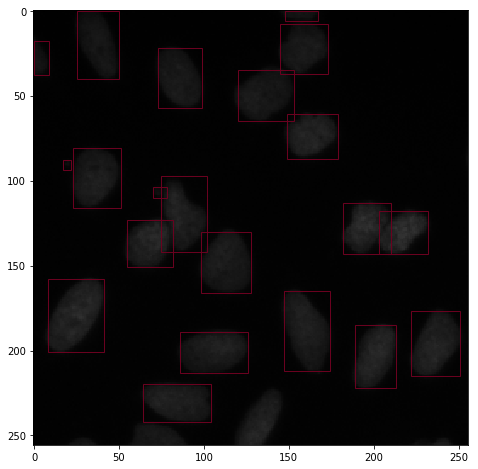

In [10]:
import matplotlib
seg_gen = ImageSegmentationGenerator().flow(train_dict, {'nucleus': 1})
x_out, _ = seg_gen.next()
print('x', len(x_out))
for x in x_out:
    print('\t', x.shape)

(target_bounding_boxes, target_image, _, _, target_scores) = x_out
target_bounding_boxes = np.squeeze(target_bounding_boxes)
target_image = np.squeeze(target_image)
target_scores = np.argmax(target_scores, -1)
target_scores = np.squeeze(target_scores)

_, axis = plt.subplots(1, figsize=(12, 8))
axis.imshow(target_image)

for target_index, target_score in enumerate(target_scores):
    if target_score > 0:
        xy = [
            target_bounding_boxes[target_index][0],
            target_bounding_boxes[target_index][1]
        ]

        w = target_bounding_boxes[target_index][2] - target_bounding_boxes[target_index][0]
        h = target_bounding_boxes[target_index][3] - target_bounding_boxes[target_index][1]

        rectangle = matplotlib.patches.Rectangle(xy, w, h, 
                                                 edgecolor=plt.cm.RdBu(target_score), 
                                                 facecolor="none")
        axis.add_patch(rectangle)

matplotlib.pyplot.show()

In [11]:
import keras
from keras.layers import Input
from keras_rcnn.models import RCNN
img_in = Input((None, None, 3))
rcnn_model = RCNN(img_in, 2)
optimizer = keras.optimizers.Adam(0.0001)
rcnn_model.compile(optimizer)
print('Input:', rcnn_model.get_input_shape_at(0))
print('Output:', rcnn_model.get_output_shape_at(0))
#rcnn_model.summary()

Input: [(None, None, 4), (None, None, None, 3), (None, None, 2), (None, 3)]
Output: [(1, 1, 8), (1, 1, 2)]


/opt/conda/lib/python3.6/site-packages/keras_rcnn/models/_rcnn.py:91: UserWarning: Output "object_detection_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "object_detection_1" during training.
  super(RCNN, self).compile(optimizer, None)


In [12]:
def fit_gen():
    for (boxes, target_img, img_b, meta_out, target_scores), _ in seg_gen:
        # for debugging
        #print([(i, x.shape) for i, x in enumerate((boxes, target_img, img_b, meta_out, target_scores))])
        yield [boxes, target_img, target_scores, meta_out], None
rcnn_model.fit_generator(fit_gen(),
                        steps_per_epoch = 20,
                        epochs = 2)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2
20/20 [==============================] - 118s 6s/step - loss: 23.6705
Epoch 2/2
20/20 [==============================] - 110s 5s/step - loss: 9.5184


# Show Predictions on Single Image
Here we apply the model to the test data

In [13]:
test_ds = next(fit_gen())
y_anchors, y_scores = rcnn_model.predict(test_ds[0])
print(y_anchors.shape, y_scores.shape)

(1, 300, 4) (1, 300, 2)


Some issues to sort out, but seems to be vaguely in the right direction

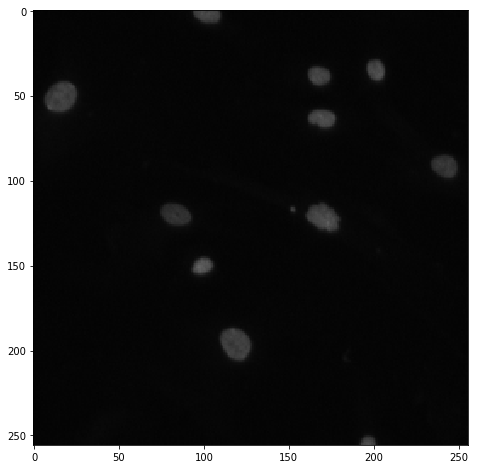

In [14]:
target_bounding_boxes = np.squeeze(y_anchors)
target_image = np.squeeze(test_ds[0][1][0])
target_scores = np.argmax(np.squeeze(y_scores), -1)

_, axis = plt.subplots(1, figsize=(12, 8))

axis.imshow(target_image)

for target_index, target_score in enumerate(target_scores):
    if target_score > 0:
        xy = [
            target_bounding_boxes[target_index][0],
            target_bounding_boxes[target_index][1]
        ]

        w = target_bounding_boxes[target_index][2] - target_bounding_boxes[target_index][0]
        h = target_bounding_boxes[target_index][3] - target_bounding_boxes[target_index][1]

        rectangle = matplotlib.patches.Rectangle(xy, w, h, 
                                                 edgecolor=plt.cm.RdBu(target_score), 
                                                 facecolor="none")
        axis.add_patch(rectangle)

matplotlib.pyplot.show()

# Prepare the test data (WIP)

In [15]:
%%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    

test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

65 images to process
CPU times: user 832 ms, sys: 12 ms, total: 844 ms
Wall time: 836 ms


In [16]:
%%time
test_img_df['masks'] = test_img_df['images'].map(lambda x: simple_cnn.predict(np.expand_dims(x, 0))[0, :, :, 0])

NameError: name 'simple_cnn' is not defined

## Show a few predictions

KeyError: 'masks'

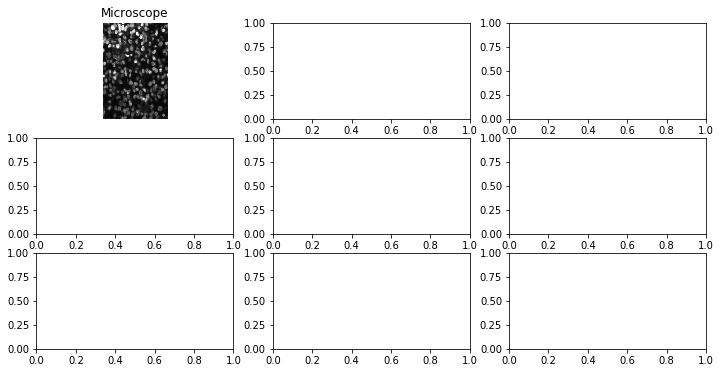

In [17]:
n_img = 3
from skimage.morphology import closing, opening, disk
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))
fig, m_axs = plt.subplots(3, n_img, figsize = (12, 6))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(), 
                                     m_axs):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')
    
    c_clean.imshow(clean_img(d_row['masks']))
    c_clean.axis('off')
    c_clean.set_title('Clean')

# Check RLE
Check that our approach for RLE encoding (stolen from [here](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python)) works

In [18]:
from skimage.morphology import label # label regions
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

## Calculate the RLEs for a Train Image

In [19]:
_, train_rle_row = next(train_img_df.tail(5).iterrows()) 
train_row_rles = list(prob_to_rles(train_rle_row['masks']))

## Take the RLEs from the CSV

In [20]:
tl_rles = train_labels.query('ImageId=="{ImageId}"'.format(**train_rle_row))['EncodedPixels']

## Check
Since we made some simplifications, we don't expect everything to be perfect, but pretty close

In [21]:
match, mismatch = 0, 0
for img_rle, train_rle in zip(sorted(train_row_rles, key = lambda x: x[0]), 
                             sorted(tl_rles, key = lambda x: x[0])):
    for i_x, i_y in zip(img_rle, train_rle):
        if i_x == i_y:
            match += 1
        else:
            mismatch += 1
print('Matches: %d, Mismatches: %d, Accuracy: %2.1f%%' % (match, mismatch, 100.0*match/(match+mismatch)))

Matches: 360, Mismatches: 0, Accuracy: 100.0%


# Calculate RLE for all the masks
Here we generate the RLE for all the masks and output the the results to a table. We use a few morphological operations to clean up the images before submission since they can be very messy (remove single pixels, connect nearby regions, etc)

In [22]:
test_img_df['rles'] = test_img_df['masks'].map(clean_img).map(lambda x: list(prob_to_rles(x)))

KeyError: 'masks'

In [23]:
out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list+=[dict(ImageId=c_row['ImageId'], 
                             EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

KeyError: 'rles'

In [24]:
out_pred_df[['ImageId', 'EncodedPixels']].to_csv('predictions.csv', index = False)

NameError: name 'out_pred_df' is not defined